<h2> Predicting PGA Rank with Machine Learning </h2>

<p> <img class="img-fluid" alt="Responsive image"  src="https://picsum.photos/1200/200/?image=47"></p>

<p>

In this post we will take the pga stats data found on [pga.com](https://www.pgatour.com/stats.html) and use a Random Forrest model to predict the 2018 PGA Ranks by training our algorithm on previous year data.  We will then explore the feature importance to better understand what metrics were important in predicting rank. 

</p>

<h3> Packages </h3>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import re
import my_utils


%matplotlib inline

<p> 
For this project we will be using [scikit-learn](https://scikit-learn.org/) which is a machine learning library for Python.  Instead of importing the entire package we grab the model "RandomForestRegressor" and the two scoring metrics that we need.  We also are importing a package called my_utils wich contains some custom functions I wrote to assist in the project.  
</p>



<h3> The Data </h3>

In [ ]:
my_utils.extract_pga_data()
my_utils.transform_pga_data()

<p>
If you go to [pga/stats](https://www.pgatour.com/stats.html) you'll notice the data isn't all in one place for us to grab and throw into our algortithm.  This is a typical issue with machine learning and you'll find that most of your time is spent wrangling the data vs actually training the algorithm.  

The my_utils.extract_pga_data() function extracts all the tables found on pga.com and then the my_utils.transform_pga_data() takes those tables and combines them into a single table and exports it into a file called "pga_stats.csv". I'll make a post in the future to cover both these functions.

<p>

In [2]:
df = pd.read_csv('pga_stats.csv', low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17648 entries, 0 to 17647
Columns: 1168 entries, Player Name to SG_Putting_TOTAL PUTTS GAINED
dtypes: float64(998), int64(1), object(169)
memory usage: 157.3+ MB


In [4]:
df.head(3)

,Player Name,GIR_Percentage_from_Fairway_ROUNDS,GIR_Percentage_from_Fairway_%,GIR_Percentage_from_Fairway_GREENS HIT,GIR_Percentage_from_Fairway_# OF HOLES,Greens_in_Regulation_Percentage_ROUNDS,Greens_in_Regulation_Percentage_%,Greens_in_Regulation_Percentage_GREENS HIT,Greens_in_Regulation_Percentage_# HOLES,Greens_in_Regulation_Percentage_RELATIVE/PAR,...,Left_Tendency_%,Left_Tendency_NUMBER OF TIMES,Left_Tendency_ATTEMPTS,Left_Tendency_AVG RTP SCORE,Right_Tendency_EVENTS,Right_Tendency_%,Right_Tendency_NUMBER OF TIMES,Right_Tendency_ATTEMPTS,Right_Tendency_AVG RTP SCORE,SG_Putting_TOTAL PUTTS GAINED
0,Fred Couples,71.0,84.14,467.0,555.0,71.0,71.13,845.0,1188.0,-0.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tiger Woods,82.0,82.08,591.0,720.0,82.0,75.15,974.0,1296.0,-0.37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Stewart Cink,98.0,80.67,651.0,807.0,98.0,69.11,1132.0,1638.0,-0.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<p>
Above we import the "pga_stats.csv" which was created when we ran "my_utils.transform_pga_data()".  The dataframe it produces contains over 1,168 columns(featues).  We could do some dimensionality reduction such as PCA but for now we'll leave it be.  Before we start optimizing our model we first need a benchmark result.  
</p>

<h3> Data Preparation </h3>

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17648 entries, 0 to 17647
Columns: 1168 entries, Player Name to SG_Putting_TOTAL PUTTS GAINED
dtypes: float64(998), int64(1), object(169)
memory usage: 157.3+ MB


In [6]:
f'Null Values: {df.isna().sum().sum()}'

'Null Values: 16680149'

<p>
Unfortunately we can't just feed the data as is to our model.  The random forest algorithm can only handle non null numeric values.  We currently have both null values and 169 non numeric columns(object).
</p>

In [7]:
df = df.dropna(thresh=1000)
df = df.dropna(thresh=1500, axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2850 entries, 2661 to 16824
Columns: 1136 entries, Player Name to Right_Tendency_AVG RTP SCORE
dtypes: float64(967), int64(1), object(168)
memory usage: 24.7+ MB


In [9]:
f'Null Values: {df.isna().sum().sum()}'

'Null Values: 97374'

<p>
Pandas makes it very easy to drop null rows or columns.  Above we do both.  The first line drops all rows that don't have at least 1,000 non null values and then again for all columns that do not have at least 1,500 values.  
</p>

In [10]:
df.loc[:,df.dtypes == object] = df.loc[:,df.dtypes == object].applymap(my_utils.make_numeric)
df.loc[:,df.dtypes == object] = df.loc[:,df.dtypes == object].applymap(lambda df:  0 if df=='E' else df)

<p>
We now need to handle the non numeric values.  We could just decide to remove these columns but instead let's try and force as many values as possible such as " 6'11'' " into a numeric values "6.11".  Finally there are some values represented as 'E'.  I assume that stands for even par so I convert them to 0.  
</p>

In [11]:
df = df.fillna(df.mean())

players = df.loc[:,'Player Name']
df = df.drop('Player Name', axis=1)

# Drop Object Columns that did not convert
df = df.drop(df.loc[:,df.dtypes == object], axis=1)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2850 entries, 2661 to 16824
Columns: 1133 entries, GIR_Percentage_from_Fairway_ROUNDS to Right_Tendency_AVG RTP SCORE
dtypes: float64(1132), int64(1)
memory usage: 24.7 MB


In [13]:
f'Null Values: {df.isna().sum().max()}'

'Null Values: 0'

The last step we need to do if fill the null values.  I used the mean for each column but it may be worth testing other values to see if it improves the result of the algorithm.  Before we remove the object columns that didn't convert to a numeric value we need to save the "Player Name" column in a seperate dataframe.  We will be joining this data back to our final results later on.

<h3> Train Test Split </h3>

In [14]:
target = df[['All-Around_Ranking_TOTAL', 'Year']]

<p> <img class="img-fluid" alt="Responsive image" src="https://i.imgur.com/2QrBEt0.png"></p>&#10;<p>

In [25]:
ranking = pd.read_csv(r'data/2018/POINTSRANKINGS/All-Around_Ranking.csv')

In [29]:
ranking['All-Around_Ranking_RANK LAST WEEK'] = ranking['All-Around_Ranking_RANK LAST WEEK'].str.replace('T','').map(int)

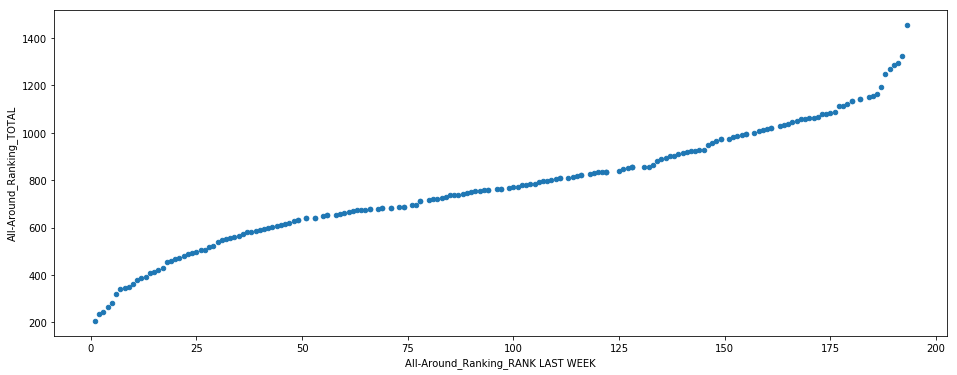

In [41]:
ranking.plot(kind='scatter', x='All-Around_Ranking_RANK LAST WEEK', y='All-Around_Ranking_TOTAL', figsize=(16,6));

In [ ]:
target['All-Around_Ranking_TOTAL'].plot('hist')

In [ ]:
feature = df[df.columns[~df.columns.str.contains('par|rank|rtp|score|birdie|ball_striking|total_driving|rounds|total putts|round|sg:|sg_',case=False)]]

In [ ]:
feature_train = feature[~feature['Year'].isin([2018])]
target_train = target[~target['Year'].isin([2018])]['All-Around_Ranking_TOTAL']

feature_test = feature[feature['Year'].isin([2018])]
target_test = target[target['Year'].isin([2018])]['All-Around_Ranking_TOTAL']

In [ ]:
rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1)

In [ ]:
rfr.fit(feature_train, target_train)

In [ ]:
target_predict = rfr.predict(feature_test)

In [ ]:
r2_score(target_test, target_predict)

In [ ]:
np.sqrt(mean_squared_error(target_test, target_predict))

In [ ]:
feature_importance_df = pd.DataFrame({'feature': feature_train.columns, 'importance': rfr.feature_importances_})

In [ ]:
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

In [ ]:
# In the blog show the original feature importance without removing columns and explain the process of removing them

my_utils.plot_feature_importances(feature_importance_df, table=False)

In [ ]:
results = pd.merge(target_test.to_frame(), players.to_frame(), left_index=True, right_index=True, how='left')

In [ ]:
results = results.reset_index(drop=True)

In [ ]:
results = pd.concat([results, pd.Series(target_predict)], axis=1)

In [ ]:
results.columns = ['2018 Rank Score', 'Player Name', '2018 Rank Score Predict']

In [ ]:
results[['2018 Rank Score', '2018 Rank Score Predict']] = results[['2018 Rank Score', '2018 Rank Score Predict']].astype(int)

In [ ]:
results = results.set_index('Player Name')

In [ ]:
results.sort_values('2018 Rank Score').plot()

In [ ]:
results.sort_values('2018 Rank Score').plot(x='2018 Rank Score', y='2018 Rank Score Predict', kind='scatter')

In [ ]:
results['Error'] = np.abs(results['2018 Rank Score'] - results['2018 Rank Score Predict'])

In [ ]:
results.sort_values('2018 Rank Score')

In [ ]:
results.sort_values('Error', ascending=False)

In [ ]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns